In [15]:
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
import random
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [16]:
#check if guess
def is_guess(model, row):
    if not model.has_index_for(row['question']):
        return True
    for i in range(4):
        if model.has_index_for(row[str(i)]):
            return False
    return True

In [17]:
#find the closest synonym to the question-word. Use the similarity method from Gensim.
def guess_synonym(model):
    data = pd.read_csv('synonyms.csv')
    output_data = []
    most_similar = 0
    guess_word = ""
    label = ""
    for row in data.to_dict(orient="records"):
        for i in range(4):
            if (is_guess(model, row)):
                random_word_key = random.randint(0,3)
                guess_word = row[str(random_word_key)]
                label = "guess"
                break
            if not model.has_index_for(row[str(i)]):
                continue
            else:
                model_similarity = model.similarity(row['question'], row[str(i)])
            if (model_similarity > most_similar):
                most_similar = model_similarity
                guess_word = row[str(i)]
        if (label != "guess"):
            label = "correct" if (guess_word == row['answer']) else "wrong"

        output_data.append({"question": row['question'], "answer": row['answer'], "guess": guess_word, "label": label})
        most_similar = 0
        guess_word = ""
        label = ""
    return output_data

In [18]:
#write results to csv file
def write_results(model_name, data):
    # with open(f'{model_name}-details.csv', 'w') as new_file:
    fieldnames = data[0].keys()
    fieldnames = output_data[0].keys()
    pd.DataFrame(output_data, columns=fieldnames).to_csv(
    f'{model_name}-details.csv', sep=',', index=False)

In [19]:
#write analysis file
def write_analysis(model_name, model, results):
    vocab_size = len(model)
    results_per_label = Counter(element['label'] for element in results)
    c = results_per_label['correct']
    v = 80-results_per_label['guess']
    model_accuracy = c/v
    pd.DataFrame([model_name, vocab_size, c, v, model_accuracy]).T.to_csv(
    'analysis.csv', sep=',', index=False, header=False, mode='a')

In [20]:
#load the pretrained embedding models !!WARNING!! TAKES A WHILE TO RUN
model_names = ["glove-twitter-50", "glove-wiki-gigaword-50", "glove-wiki-gigaword-100", "glove-wiki-gigaword-200"]
models = np.array([])
for model_name in model_names:
    models = np.append(models, api.load(model_name))

In [21]:
# store the results, perform the analysis
for i in range(len(model_names)):
    output_data = guess_synonym(models[i])
    write_results(model_names[i], output_data)
    write_analysis(model_names[i], models[i], output_data)

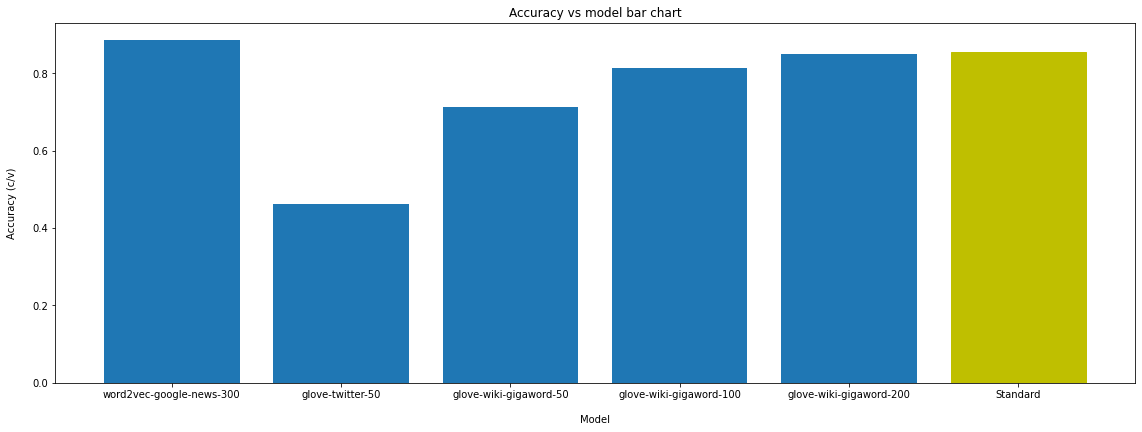

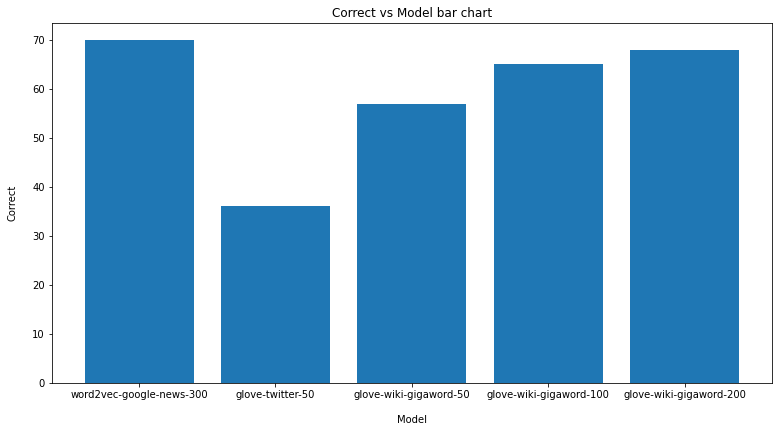

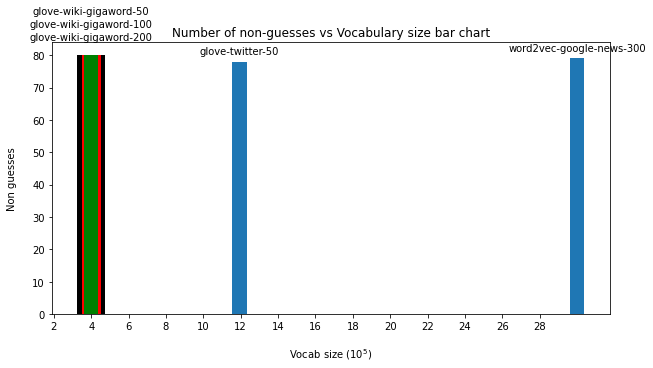

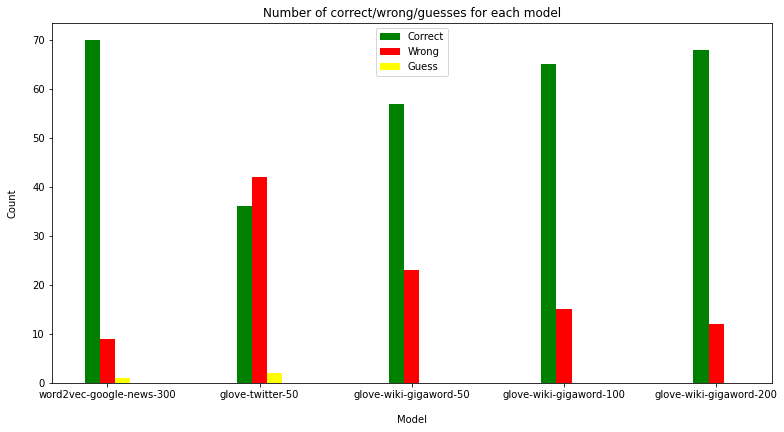

In [22]:
headers = ['model', 'vocab', 'c', 'v', 'percent']
df = pd.read_csv('analysis.csv', names=headers)

#Pecent vs model bar chart
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0,0,1,1])
x_axis = df['model'].tolist()
y_axis = df['percent'].tolist()
x_axis.append("Standard")
y_axis.append(0.8557)
bars = ax.bar(x_axis,y_axis)
bars[-1].set_color('y')
plt.xlabel("Model", labelpad=15)
plt.ylabel("Accuracy (c/v)", labelpad=15)
plt.title("Accuracy vs model bar chart")
plt.show()

#Correct vs Model bar chart
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
x_axis = df['model'].tolist()
y_axis = df['c'].tolist()
ax.bar(x_axis,y_axis)
plt.xlabel("Model", labelpad=15)
plt.ylabel("Correct", labelpad=15)
plt.title("Correct vs Model bar chart")
plt.show()

#Correct vs Model bar chart
try:
    fig = plt.figure(figsize=(10, 5))
    y_axis = df['v'].tolist()
    x_axis = (df['vocab']/(10**5)).tolist()

    dups_x = np.array([],dtype=np.float64)
    dups_y = np.array([],dtype=np.float64)
    dups_names = np.array([])

    for i in range(len(x_axis)):
        if x_axis.count(x_axis[i]) > 1:
            dups_x = np.append(dups_x,x_axis[i])
            dups_y = np.append(dups_y,y_axis[i])
            dups_names = np.append(dups_names,df['model'].tolist()[i])
    for i in range(len(dups_x)):
        x_axis.remove(dups_x[i])
        y_axis.remove(dups_y[i])
    color=['black', 'red', 'green', 'blue', 'cyan']
    plt.xticks(np.arange(0,max(x_axis), len(x_axis)))
    rects = plt.bar(x_axis,y_axis)
    for i in range(len(rects)):
        plt.text(rects[i].get_x() + rects[i].get_width()/2., 1.02*rects[i].get_height(),
        '%s' % df['model'].tolist()[i],ha='center', va='bottom')
    dupe_rects = np.array([])
    for i in range(len(dups_x)):
        rect = plt.bar(dups_x[i],dups_y[i], color=color[i], width=len(dups_x)/(i+2))
        dupe_rects = np.append(dupe_rects,rect)

    for i in range(len(dupe_rects)):
        plt.text(dupe_rects[i].get_x() + dupe_rects[i].get_width()/2., 
        1.05*dupe_rects[i].get_height()+4*((len(dupe_rects)-(i+1))),'%s' 
        % dups_names[i],ha='center', va='bottom')

    plt.ylabel("Non guesses", labelpad=15)
    plt.xlabel("Vocab size $(10^5)$", labelpad=15)
    plt.title("Number of non-guesses vs Vocabulary size bar chart")
    plt.show()
except Exception:
    pass

#Number of correct/wrong/guesses for each model
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
labels = df['model'].to_list()
x_axis = np.arange(len(labels))
for i in range(len(labels)):

    correct = df['c'][i]
    guess = 80 - df['v'][i]
    wrong = 80 - correct - guess

    rects= np.array([])
    width = 0.1  # the width of the bars
    rect1 = plt.bar(x_axis[i] - width, correct, width, color="green", label = "Correct")
    rects = np.append(rects,rect1)
    rect2 = plt.bar(x_axis[i], wrong, width, color="red", label="Wrong")
    rects = np.append(rects,rect2)
    rect3 = plt.bar(x_axis[i] + width, guess, width, color="yellow", label="Guess")
    rects = np.append(rects,rect3)

plt.xticks(x_axis, labels)
plt.xlabel("Model", labelpad=15)
plt.ylabel("Count", labelpad=15)
plt.legend(rects,["Correct","Wrong","Guess"])
plt.title("Number of correct/wrong/guesses for each model")
plt.show()

In [23]:
#Table of most successful answers of standard compared to result of models
gold_standard_df = pd.read_csv("Crowdsourced Gold-Standard for MP3.csv")
gold_standard_df['Sucess Rate'] = gold_standard_df['Sucess Rate'].str.replace('%', '').astype(float)
top10_sucess = gold_standard_df.nlargest(10, 'Sucess Rate')

model_names = ["word2vec-google-news-300", "glove-twitter-50", "glove-wiki-gigaword-50", "glove-wiki-gigaword-100", "glove-wiki-gigaword-200"]
for model_name in model_names:
    model_header = ['question', 'answer', 'guess', model_name]
    df_model = pd.read_csv(f'{model_name}-details.csv', names=model_header)
    df_model = df_model.loc[df_model['question'].isin(top10_sucess['Question name'].tolist())]
    df_model = df_model.drop(columns=['guess'])
    if (model_name == model_names[0]):
        df_compiled = df_model;
    else:
        df_compiled[model_name] = df_model[model_name].tolist();

df_compiled

,question,answer,word2vec-google-news-300,glove-twitter-50,glove-wiki-gigaword-50,glove-wiki-gigaword-100,glove-wiki-gigaword-200
1,enormously,tremendously,correct,correct,correct,correct,correct
12,solitary,alone,wrong,wrong,wrong,wrong,correct
20,costly,expensive,correct,correct,correct,correct,correct
24,often,frequently,correct,wrong,correct,correct,correct
27,narrow,thin,correct,wrong,wrong,correct,correct
28,arranged,planned,correct,correct,correct,correct,correct
29,infinite,limitless,correct,wrong,correct,correct,correct
51,built,constructed,correct,wrong,correct,correct,correct
52,tasks,jobs,correct,wrong,correct,correct,correct
78,bigger,larger,correct,wrong,wrong,correct,correct


In [24]:
#Table of least successful answers of standard compared to result of model
top10_wrong = gold_standard_df.nsmallest(10, 'Sucess Rate')
for model_name in model_names:
    model_header = ['question', 'answer', 'guess', model_name]
    df_model = pd.read_csv(f'{model_name}-details.csv', names=model_header)
    df_model = df_model.loc[df_model['question'].isin(top10_wrong['Question name'].tolist())]
    df_model = df_model.drop(columns=['guess'])
    if (model_name == model_names[0]):
        df_compiled = df_model;
    else:
        df_compiled[model_name] = df_model[model_name].tolist();

df_compiled

,question,answer,word2vec-google-news-300,glove-twitter-50,glove-wiki-gigaword-50,glove-wiki-gigaword-100,glove-wiki-gigaword-200
2,provisions,stipulations,correct,wrong,correct,correct,correct
3,haphazardly,randomly,correct,wrong,correct,correct,wrong
23,make,earn,correct,wrong,correct,correct,correct
30,showy,striking,wrong,wrong,wrong,wrong,wrong
35,prolific,productive,correct,wrong,wrong,correct,correct
37,peculiarly,uniquely,correct,guess,correct,correct,correct
56,wildly,furiously,correct,correct,correct,correct,correct
57,hailed,acclaimed,wrong,wrong,wrong,wrong,wrong
74,figure,solve,correct,wrong,wrong,wrong,wrong
76,fashion,manner,correct,wrong,correct,correct,correct
